# Visualization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import pandas as pd
import seaborn as sns
import re

## Helper Methods

In [2]:
def metrics_to_dict(lst):
    res = {}
    for i in lst:
        k, v = i.split(": ")
        v = v.replace("\n", '')
        res[k] = v
    return res

def get_agent_metrics(metrics):
    del metrics['page']
    del metrics['ground_truth']
    del metrics['align_id']
    del metrics['like_id']
    return metrics

def get_detailed_metrics(model, sim_name):
    path = f"{model}/{sim_name}/metrics.txt"
    with open(path, 'r') as f:
        metrics = f.readlines()
    offline_metrics = metrics_to_dict(metrics)

    path = f"{model}/{sim_name}/ctr.pkl"
    with open(path, 'rb') as f:
        metrics = pickle.load(f)
    ctr = list(metrics.values())
    
    # To get overall and positive score from agent interview response
    path = f"{model}/{sim_name}/interview/"
    n = len(os.listdir(path))
    res = {}
    for i in range(n):
        temp_path = f"{path}{i}.pkl"
        with open(temp_path, 'rb') as f:
            data = pickle.load(f)

        if len(data['interview']) == 2:
            res[i] = {'overall_rating': int(data['interview'][0].split(";")[0]),
                     'surprise_rating': int(data['interview'][1].split(";")[0])}
        else:
            res[i] = {'overall_rating': int(re.sub(r'[^\d]', '', data['interview'][0])),
                     'surprise_rating': int(re.sub(r'[^\d]', '', data['interview'][2]))}

    path = f"{model}/{sim_name}/behavior/"
    n = len(os.listdir(path))
    online_metrics = {}
    for i in range(n):
        temp_path = f"{path}{i}.pkl"
        with open(temp_path, 'rb') as f:
            metrics = pickle.load(f)
        online_metrics[i] = get_agent_metrics(metrics[1])
        online_metrics[i]['click_rate'] = ctr[0]    
        online_metrics[i]['overall_rating'] = res[i]['overall_rating']
        online_metrics[i]['surprise_rating'] = res[i]['surprise_rating']

    return(offline_metrics, online_metrics)

def offline_metrics_df_builder(sys1, sys2, sys3, sys4):
    data = {
        'model': ['Random', 'Pop', 'LightGCN', 'MultVAE'],
        'total_time': [
            sys1['Total simulation time'],
            sys2['Total simulation time'],
            sys3['Total simulation time'],
            sys4['Total simulation time']
        ],
        'average_recall': [
            sys1['Average recall'],
            sys2['Average recall'],
            sys3['Average recall'],
            sys4['Average recall']
        ],
        'average_precision': [
            sys1['Average presion'],
            sys2['Average presion'],
            sys3['Average presion'],
            sys4['Average presion']
        ],
        'overall_cr': [
            sys1['Overall click rate'],
            sys2['Overall click rate'],
            sys3['Overall click rate'],
            sys4['Overall click rate']
        ],
        'avg_likes': [
            sys1['Average number of likes'],
            sys2['Average number of likes'],
            sys3['Average number of likes'],
            sys4['Average number of likes']
        ]
    }
    df = pd.DataFrame(data)
    df['total_time'] = df['total_time'].str.replace('s', '').astype(float)
    df['average_recall'] = df['average_recall'].astype(float)
    df['average_precision'] = df['average_precision'].astype(float)
    df['overall_cr'] = df['overall_cr'].astype(float)
    df['avg_likes'] = df['avg_likes'].astype(float)
    return df

def online_vis_data_formatter(random, pop, gcn, vae):
    summary = {}
    summary['Random'] = random[0]
    summary['Popular'] = pop[0]
    summary['GCN'] = gcn[0]
    summary['VAE'] = vae[0]

    metrics = ['click_rate', 
               'overall_rating', 'surprise_rating', 
               'actual_click_rate', 'actual_overall_rating', 
               'actual_surprise_rating']

    df_list = []

    # Populate DataFrame
    for recommender, metrics_dict in summary.items():
        for metric in metrics:
            if metric in metrics_dict:
                if isinstance(metrics_dict[metric], list):
                    value = metrics_dict[metric]
                    value = ', '.join(map(str, value))
                else:
                    value = metrics_dict[metric]

                df_list.append({
                    'Recommender': recommender,
                    'Metric': metric,
                    'Value': value
                })

    df = pd.DataFrame(df_list)

    df['Type'] = df['Metric'].apply(lambda x: 'Actual' if 'actual' in x else 'Agent')
    df['Metric_Name'] = df['Metric'].apply(lambda x: x.replace('actual_', '') if 'actual_' in x else x)
    
    return df

def plot_online_metrics_chart(df):
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))

    sns.barplot(x="Recommender", y="Value", hue="Type", data=df[df['Metric_Name'] == 'click_rate'], ax=axs[0, 0])
    axs[0, 0].set_title('Click Through Rate by Recommender System')
    axs[0, 0].set_ylabel('Click Through Rate')
    axs[0, 0].set_xlabel('')

    sns.barplot(x="Recommender", y="Value", hue="Type", data=df[df['Metric_Name'] == 'overall_rating'], ax=axs[0, 1])
    axs[0, 1].set_title('Overall Rating by Recommender System')
    axs[0, 1].set_ylabel('Overall Rating')
    axs[0, 1].set_xlabel('')

    sns.barplot(x="Recommender", y="Value", hue="Type", data=df[df['Metric_Name'] == 'surprise_rating'], ax=axs[1, 0])
    axs[1, 0].set_title('Surprise Rating by Recommender System')
    axs[1, 0].set_ylabel('Surprise Rating')
    axs[1, 0].set_xlabel('')

    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Offline Evaluation (Agent only comparison)

## Agent only offline metrics including CTR (Random, Pop, GCN, VAE)

In [3]:
offline_metrics_random_gpt3, online_metrics_random_gpt3 = get_detailed_metrics('Random', 'gpt3.5_10')
offline_metrics_random_gpt4, online_metrics_random_gpt4 = get_detailed_metrics('Random', 'gpt4o_10')

offline_metrics_pop_gpt3, online_metrics_pop_gpt3 = get_detailed_metrics('Pop', 'gpt3.5_10')
offline_metrics_pop_gpt4, online_metrics_pop_gpt4 = get_detailed_metrics('Pop', 'gpt4o_10')

offline_metrics_gcn_gpt3, online_metrics_gcn_gpt3 = get_detailed_metrics('LightGCN', 'gpt3.5_10')
offline_metrics_gcn_gpt4, online_metrics_gcn_gpt4 = get_detailed_metrics('LightGCN', 'gpt4o_10')

offline_metrics_vae_gpt3, online_metrics_vae_gpt3 = get_detailed_metrics('MultVAE', 'gpt3.5_10')
offline_metrics_vae_gpt4, online_metrics_vae_gpt4 = get_detailed_metrics('MultVAE', 'gpt4o_10')

In [4]:
metrics_df_gpt3 = offline_metrics_df_builder(offline_metrics_random_gpt3,
                                             offline_metrics_pop_gpt3,
                                             offline_metrics_gcn_gpt3,
                                             offline_metrics_vae_gpt3)

metrics_df_gpt4 = offline_metrics_df_builder(offline_metrics_random_gpt4,
                                             offline_metrics_pop_gpt4,
                                             offline_metrics_gcn_gpt4,
                                             offline_metrics_vae_gpt4)

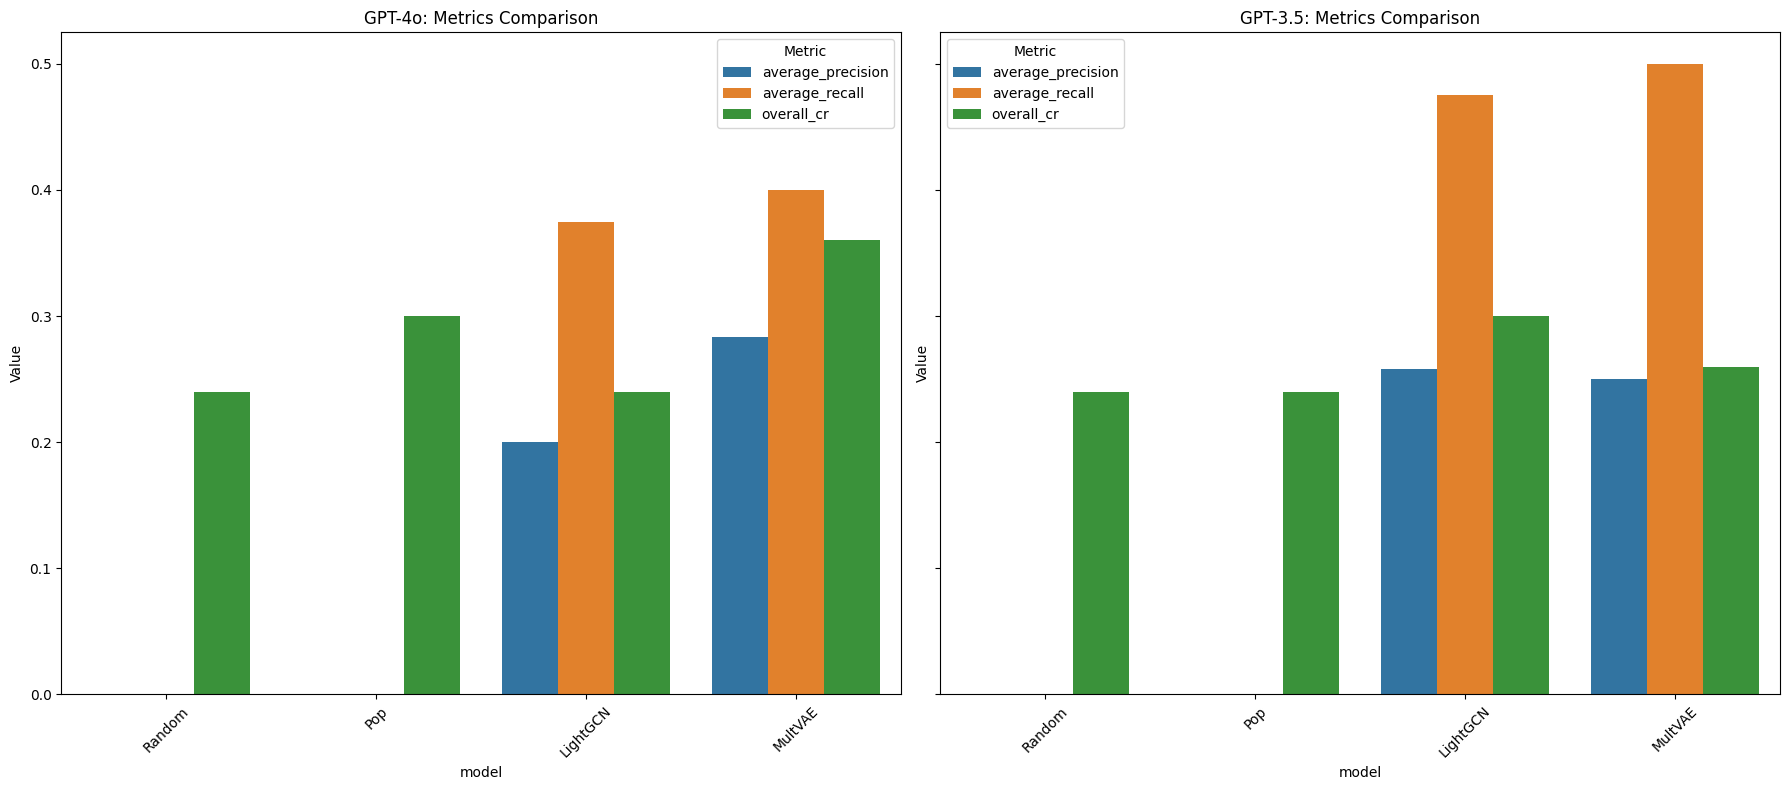

In [5]:
metrics = ['average_precision', 'average_recall', 'overall_cr']
df_melted_gpt3 = metrics_df_gpt3.melt(id_vars='model', value_vars=metrics, var_name='Metric', value_name='Value')
df_melted_gpt4 = metrics_df_gpt4.melt(id_vars='model', value_vars=metrics, var_name='Metric', value_name='Value')

fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

sns.barplot(x='model', y='Value', hue='Metric', data=df_melted_gpt3, ax=axes[0])
axes[0].set_title('GPT-4o: Metrics Comparison')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.barplot(x='model', y='Value', hue='Metric', data=df_melted_gpt4, ax=axes[1])
axes[1].set_title('GPT-3.5: Metrics Comparison')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

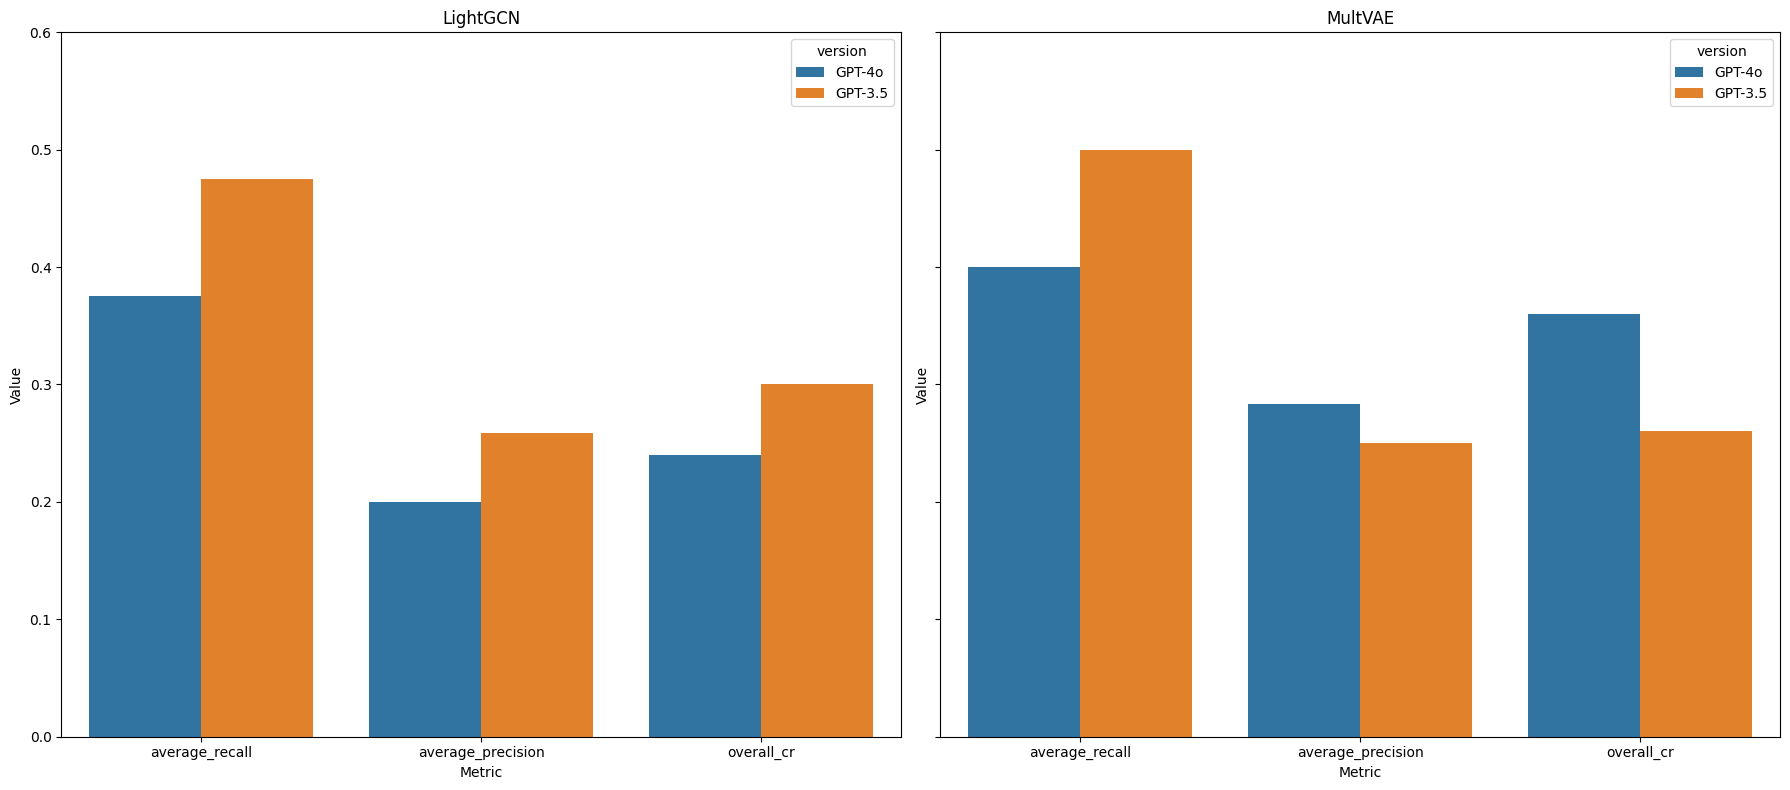

In [6]:
metrics_df_gpt3['version'] = 'GPT-4o'
metrics_df_gpt4['version'] = 'GPT-3.5'

metrics_df_combined = pd.concat([metrics_df_gpt3, metrics_df_gpt4])

metrics_df_lightgcn = metrics_df_combined[metrics_df_combined['model'] == 'LightGCN']
metrics_df_multvae = metrics_df_combined[metrics_df_combined['model'] == 'MultVAE']

df_melted_lightgcn = metrics_df_lightgcn.melt(id_vars=['model', 'version'], value_vars=['average_recall', 'average_precision', 'overall_cr'], var_name='Metric', value_name='Value')
df_melted_multvae = metrics_df_multvae.melt(id_vars=['model', 'version'], value_vars=['average_recall', 'average_precision', 'overall_cr'], var_name='Metric', value_name='Value')

fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

sns.barplot(x='Metric', y='Value', hue='version', data=df_melted_lightgcn, ax=axes[0])
axes[0].set_title('LightGCN')
axes[0].set_ylim(0, 0.6)

sns.barplot(x='Metric', y='Value', hue='version', data=df_melted_multvae, ax=axes[1])
axes[1].set_title('MultVAE')
axes[1].set_ylim(0, 0.6)

plt.tight_layout()
plt.show()

In [7]:
metrics_df_gpt4

,model,total_time,average_recall,average_precision,overall_cr,avg_likes,version
0,Random,62.29,0.000,0.000000,0.24,1.9,GPT-3.5
1,Pop,57.85,0.000,0.000000,0.24,0.8,GPT-3.5
2,LightGCN,56.76,0.475,0.258333,0.30,2.3,GPT-3.5
3,MultVAE,58.99,0.500,0.250000,0.26,2.6,GPT-3.5


In [8]:
metrics_df_gpt3['overall_cr'][3]

0.36

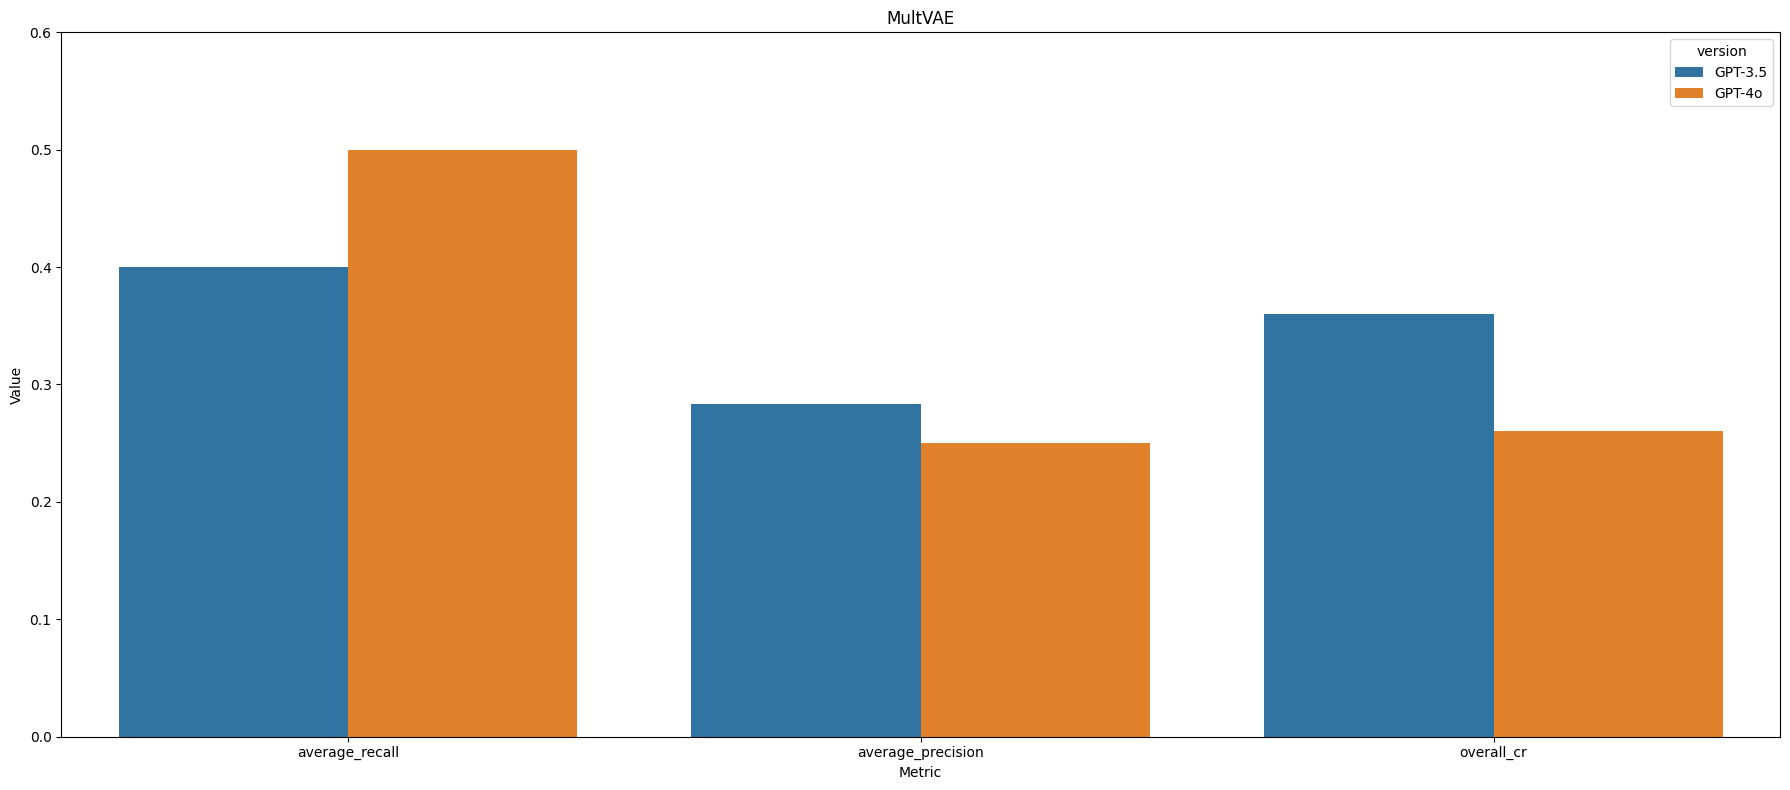

In [9]:
metrics_df_gpt3['version'] = 'GPT-3.5'
metrics_df_gpt4['version'] = 'GPT-4o'

metrics_df_combined = pd.concat([metrics_df_gpt3, metrics_df_gpt4])

metrics_df_lightgcn = metrics_df_combined[metrics_df_combined['model'] == 'LightGCN']
metrics_df_multvae = metrics_df_combined[metrics_df_combined['model'] == 'MultVAE']

df_melted_lightgcn = metrics_df_lightgcn.melt(id_vars=['model', 'version'], value_vars=['average_recall', 'average_precision', 'overall_cr'], var_name='Metric', value_name='Value')
df_melted_multvae = metrics_df_multvae.melt(id_vars=['model', 'version'], value_vars=['average_recall', 'average_precision', 'overall_cr'], var_name='Metric', value_name='Value')

fig, axes = plt.subplots(1, 1, figsize=(18, 8), sharey=True)

axes.set_ylim(0, 0.6)

sns.barplot(x='Metric', y='Value', hue='version', data=df_melted_multvae, ax=axes)
axes.set_title('MultVAE')

plt.tight_layout()
plt.show()

# Online Evaluation (User-Agent Comparison)

## User - Harri

In [10]:
# Get online and offline data of agents from the stored pickle files
offline_metrics_random_harri, online_metrics_random_harri = get_detailed_metrics('Random', 'harri')
offline_metrics_pop_harri, online_metrics_pop_harri = get_detailed_metrics('Pop', 'harri')
offline_metrics_gcn_harri, online_metrics_gcn_harri = get_detailed_metrics('LightGCN', 'harri')
offline_metrics_vae_harri, online_metrics_vae_harri = get_detailed_metrics('MultVAE', 'harri')

In [11]:
# # Formatting offline metrics from the stored data
# metrics_df_harri = offline_metrics_df_builder(offline_metrics_random_harri,
#                                               offline_metrics_pop_harri,
#                                               offline_metrics_gcn_harri,
#                                               offline_metrics_vae_harri)

In [12]:
# Adding user collected data (Feedback form) into the existing dataframe
online_metrics_random_harri[0]['actual_watch_id'] = [2662]
online_metrics_random_harri[0]['actual_watched'] = ['Presidio, The (1988)']
online_metrics_random_harri[0]['actual_rating_id'] = ['Presidio, The (1988)']
online_metrics_random_harri[0]['actual_rating'] = [3]
online_metrics_random_harri[0]['actual_click_rate'] = 0.2
online_metrics_random_harri[0]['actual_overall_rating'] = 1
online_metrics_random_harri[0]['actual_surprise_rating'] = 1

online_metrics_pop_harri[0]['watch_id'] = [2878, 2422, 2247]
online_metrics_pop_harri[0]['actual_watch_id'] = [2422, 2247]
online_metrics_pop_harri[0]['actual_watched'] = ['Body Heat', 'Runaway Bride']
online_metrics_pop_harri[0]['actual_rating_id'] = ['Body Heat', 'Runaway Bride']
online_metrics_pop_harri[0]['actual_rating'] = [4, 3]
online_metrics_pop_harri[0]['actual_click_rate'] = 0.4
online_metrics_pop_harri[0]['actual_overall_rating'] = 4
online_metrics_pop_harri[0]['actual_surprise_rating'] = 2

online_metrics_gcn_harri[0]['actual_watch_id'] = [527, 1036,  327]
online_metrics_gcn_harri[0]['actual_watched'] = ['Aladdin (1992)', 'Groundhog Day (1993)', 'Lion King, The (1994)']
online_metrics_gcn_harri[0]['actual_rating_id'] = ['Aladdin (1992)', 'Groundhog Day (1993)', 'Lion King, The (1994)']
online_metrics_gcn_harri[0]['actual_rating'] = [3, 3, 4]
online_metrics_gcn_harri[0]['actual_click_rate'] = 0.6
online_metrics_gcn_harri[0]['actual_overall_rating'] = 5
online_metrics_gcn_harri[0]['actual_surprise_rating'] = 2

online_metrics_vae_harri[0]['watch_id'] = [1036, 1078, 1149,  957,  320]
online_metrics_vae_harri[0]['actual_watch_id'] = [1036, 1078, 1149,  957,  320]
online_metrics_vae_harri[0]['actual_watched'] = ['Groundhog Day', 'When Harry Met Sally...', 'Jerry Maguire', 'The English Patient', 'Four Weddings and a Funeral']
online_metrics_vae_harri[0]['actual_rating_id'] = ['Groundhog Day', 'When Harry Met Sally...', 'Jerry Maguire', 'The English Patient', 'Four Weddings and a Funeral']
online_metrics_vae_harri[0]['actual_rating'] = [3, 4, 4, 5, 3]
online_metrics_vae_harri[0]['actual_click_rate'] = 1.0
online_metrics_vae_harri[0]['actual_overall_rating'] = 9
online_metrics_vae_harri[0]['actual_surprise_rating'] = 8

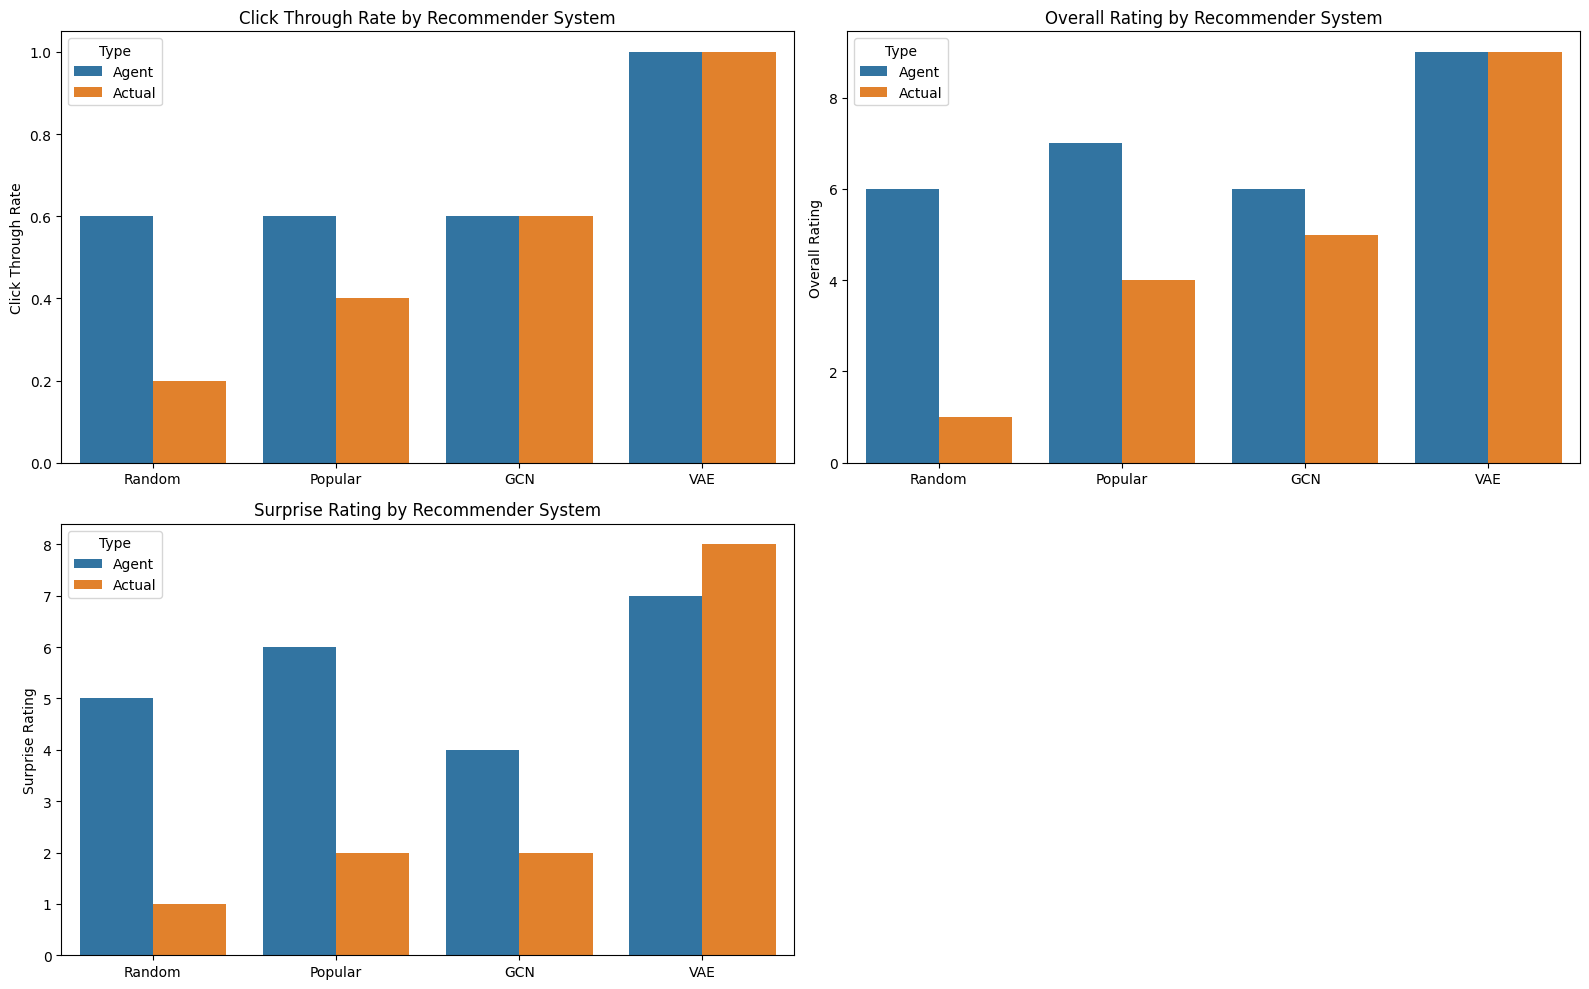

In [13]:
# Formatting and plotting the online evaluation data for comparison
online_metrics_formatted_df_harri = online_vis_data_formatter(online_metrics_random_harri,
online_metrics_pop_harri,
online_metrics_gcn_harri,
online_metrics_vae_harri,)

plot_online_metrics_chart(online_metrics_formatted_df_harri)

## User: George Vince

In [14]:
# Get online and offline data of agents from the stored pickle files
offline_metrics_random_gv, online_metrics_random_gv = get_detailed_metrics('Random', 'gv')
offline_metrics_pop_gv, online_metrics_pop_gv = get_detailed_metrics('Pop', 'gv')
offline_metrics_gcn_gv, online_metrics_gcn_gv = get_detailed_metrics('LightGCN', 'gv')
offline_metrics_vae_gv, online_metrics_vae_gv = get_detailed_metrics('MultVAE', 'gv')

In [15]:
# # Formatting offline metrics from the stored data
# metrics_df_gv = offline_metrics_df_builder(offline_metrics_random_gv,
#                                               offline_metrics_pop_gv,
#                                               offline_metrics_gcn_gv,
#                                               offline_metrics_vae_gv)

In [16]:
online_metrics_random_gv

{0: {'recommended_id': array([ 845, 2662, 3068, 3122, 3271]),
  'recommended': ['Sword in the Stone, The (1963)',
   'Presidio, The (1988)',
   'Night of the Creeps (1986)',
   'Adventures of Rocky and Bullwinkle, The (2000)',
   'Creature From the Black Lagoon, The (1954)'],
  'watch_id': [],
  'watched': ['Sword in the Stone, The', 'Presidio, The'],
  'rating_id': ['Sword in the Stone, The', 'Presidio, The'],
  'rating': [4, 3],
  'feeling': ['Enjoyed the inspirational story and life lessons.',
   'Liked the action and crime-solving elements, but not as engaging as expected.'],
  'click_rate': 0.4,
  'overall_rating': 5,
  'surprise_rating': 4}}

In [17]:
# Adding user collected data (Feedback form) into the existing dataframe
online_metrics_random_gv[0]['actual_click_rate'] = 0.4
online_metrics_random_gv[0]['actual_overall_rating'] = 4
online_metrics_random_gv[0]['actual_surprise_rating'] = 2

online_metrics_pop_gv[0]['actual_click_rate'] = 0.6
online_metrics_pop_gv[0]['actual_overall_rating'] = 5
online_metrics_pop_gv[0]['actual_surprise_rating'] = 2

online_metrics_gcn_gv[0]['actual_click_rate'] = 0.4
online_metrics_gcn_gv[0]['actual_overall_rating'] = 6
online_metrics_gcn_gv[0]['actual_surprise_rating'] = 1

online_metrics_vae_gv[0]['actual_click_rate'] = 0.6
online_metrics_vae_gv[0]['actual_overall_rating'] = 6
online_metrics_vae_gv[0]['actual_surprise_rating'] = 7

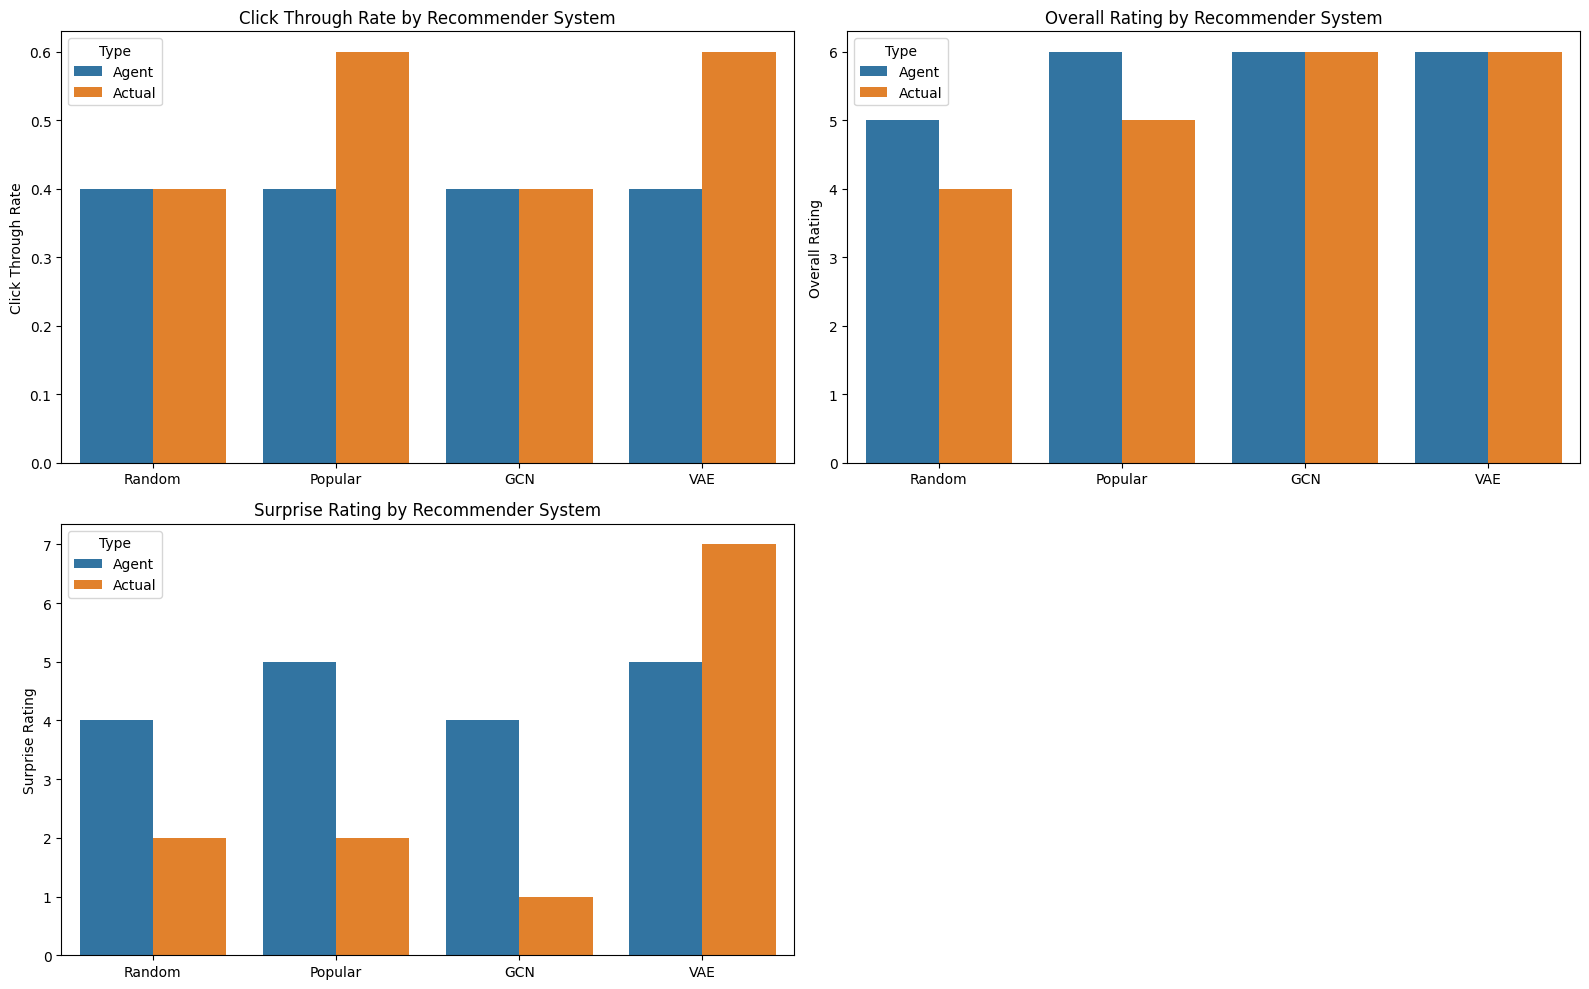

In [18]:
# Formatting and plotting the online evaluation data for comparison
online_metrics_formatted_df_gv = online_vis_data_formatter(online_metrics_random_gv,
online_metrics_pop_gv,
online_metrics_gcn_gv,
online_metrics_vae_gv,)

plot_online_metrics_chart(online_metrics_formatted_df_gv)

## User: Robbie Young

In [20]:
# Get online and offline data of agents from the stored pickle files
# offline_metrics_random_robbie, online_metrics_random_robbie = get_detailed_metrics('Random', 'robbie')
offline_metrics_pop_robbie, online_metrics_pop_robbie = get_detailed_metrics('Pop', 'robbie')
offline_metrics_gcn_robbie, online_metrics_gcn_robbie = get_detailed_metrics('LightGCN', 'robbie')
offline_metrics_vae_robbie, online_metrics_vae_robbie = get_detailed_metrics('MultVAE', 'robbie')

In [24]:
# Adding user collected data (Feedback form) into the existing dataframe

online_metrics_random_gv[0]['actual_click_rate'] = 0.4
online_metrics_random_gv[0]['actual_overall_rating'] = 4
online_metrics_random_gv[0]['actual_surprise_rating'] = 2


online_metrics_pop_robbie[0]['actual_click_rate'] = 0.6
online_metrics_pop_robbie[0]['actual_overall_rating'] = 5
online_metrics_pop_robbie[0]['actual_surprise_rating'] = 2

online_metrics_gcn_robbie[0]['actual_click_rate'] = 0.4
online_metrics_gcn_robbie[0]['actual_overall_rating'] = 6
online_metrics_gcn_robbie[0]['actual_surprise_rating'] = 1

online_metrics_vae_robbie[0]['actual_click_rate'] = 0.6
online_metrics_vae_robbie[0]['actual_overall_rating'] = 6
online_metrics_vae_robbie[0]['actual_surprise_rating'] = 7

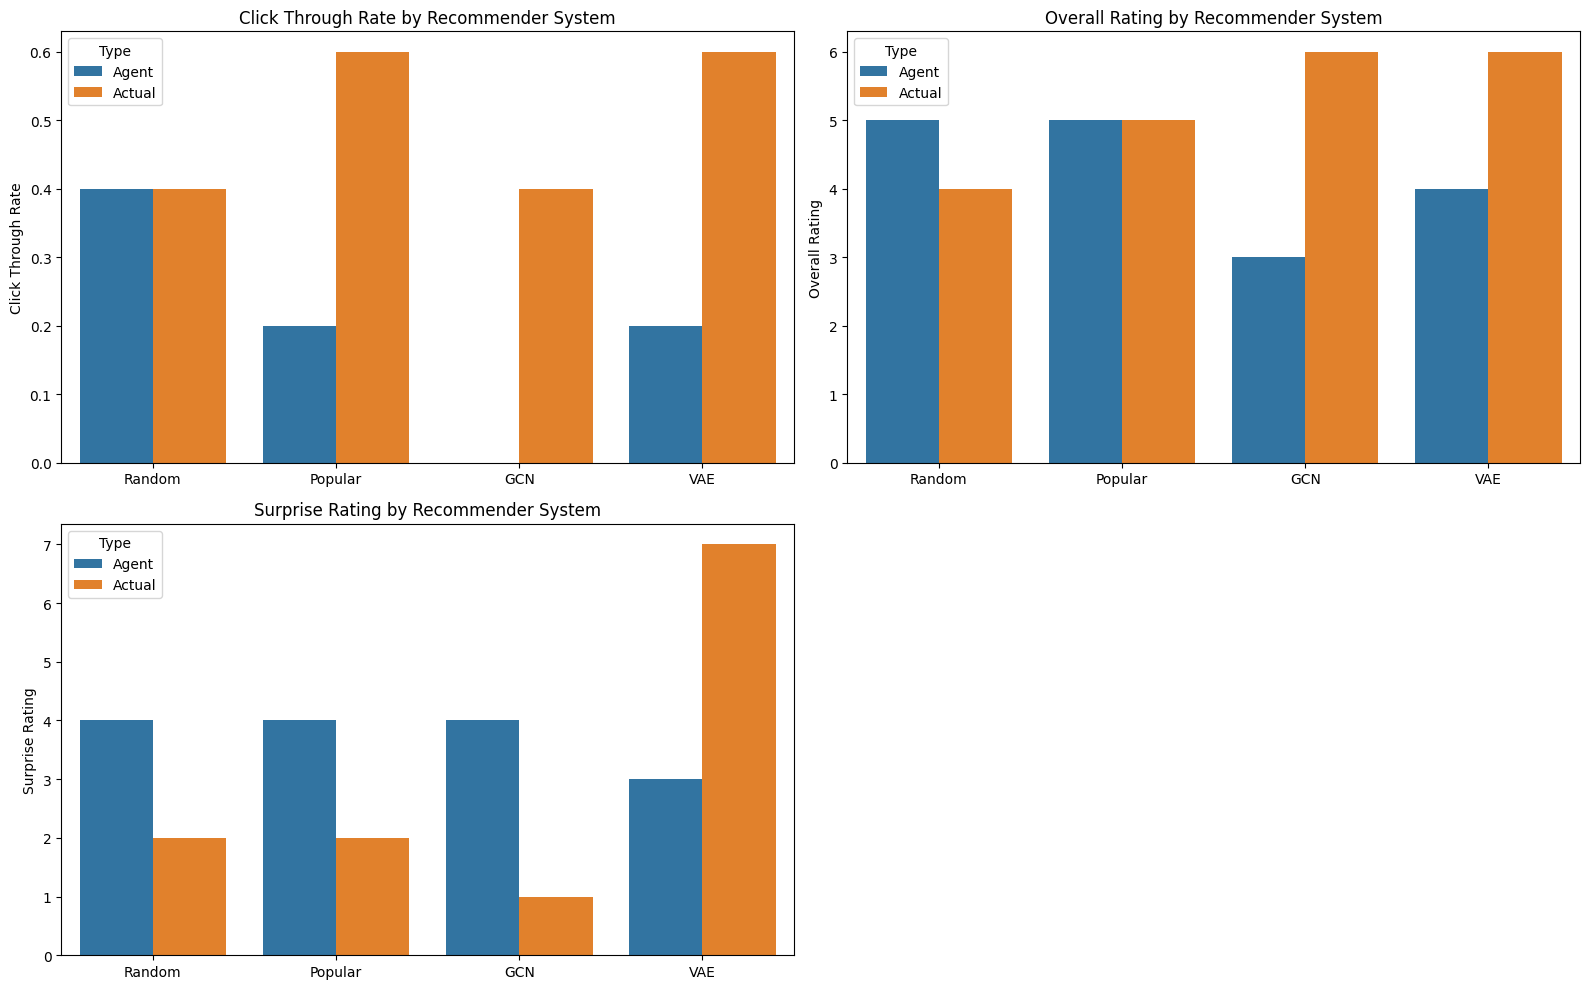

In [25]:
# Formatting and plotting the online evaluation data for comparison
online_metrics_formatted_df_robbie = online_vis_data_formatter(online_metrics_random_gv,
online_metrics_pop_robbie,
online_metrics_gcn_robbie,
online_metrics_vae_robbie,)

plot_online_metrics_chart(online_metrics_formatted_df_robbie)

In [26]:
online_metrics_gcn_robbie

{0: {'recommended_id': array([2595,   32,  527, 1959,  327]),
  'recommended': ['Toy Story 2 (1999)',
   'Babe (1995)',
   'Aladdin (1992)',
   'Shakespeare in Love (1998)',
   'Lion King, The (1994)'],
  'watch_id': [],
  'watched': [],
  'rating_id': [],
  'rating': [],
  'feeling': [],
  'click_rate': 0.0,
  'overall_rating': 3,
  'surprise_rating': 4,
  'actual_click_rate': 0.4,
  'actual_overall_rating': 6,
  'actual_surprise_rating': 1}}